<a href="https://colab.research.google.com/github/JiamanBettyWu/bios823_project/blob/betty/modeling.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
import sys
sys.path.append('/content/drive/MyDrive/BIOS823/BIOS823 Final Project')

In [47]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.neural_network import MLPClassifier

from sklearn.metrics import confusion_matrix
from sklearn.metrics import roc_auc_score
from sklearn.model_selection import GridSearchCV

from sklearn.metrics import classification_report, confusion_matrix, accuracy_score,  roc_auc_score, f1_score, precision_score, recall_score
import matplotlib.pyplot as plt
import seaborn as sns


import joblib

In [4]:
dat = pd.read_csv("/content/drive/MyDrive/BIOS823/BIOS823 Final Project/MIMIC_cleaned.csv")

In [ ]:
dat.head()

,SUBJECT_ID,HADM_ID,ADMITTIME,DISCHTIME,ETHNICITY,DIAGNOSIS,HOSPITAL_EXPIRE_FLAG,GENDER,DOB,AGE_ON_AD,SERVICES,ICU_STAY_DAYS,MULTI_ENTRY_ICU,ICD9_9955,ICD9_3893,ICD9_9604,ICD9_966,ICD9_9672,ICD9_9904,ICD9_9671,ICD9_3961,ICD9_8856,ICD9_3891,TOTAL_ITEMID_51221,TOTAL_ITEMID_51222,TOTAL_ITEMID_51248,TOTAL_ITEMID_51249,TOTAL_ITEMID_51250,TOTAL_ITEMID_51265,TOTAL_ITEMID_51277,TOTAL_ITEMID_51279,TOTAL_ITEMID_51301,TOTAL_ITEMID_50820,TOTAL_ITEMID_50868,TOTAL_ITEMID_50882,TOTAL_ITEMID_50902,TOTAL_ITEMID_50912,TOTAL_ITEMID_50931,TOTAL_ITEMID_50960,TOTAL_ITEMID_50970,...,ABNORMAL_ITEMID_51221,ABNORMAL_ITEMID_51222,ABNORMAL_ITEMID_51248,ABNORMAL_ITEMID_51249,ABNORMAL_ITEMID_51250,ABNORMAL_ITEMID_51265,ABNORMAL_ITEMID_51277,ABNORMAL_ITEMID_51279,ABNORMAL_ITEMID_51301,ABNORMAL_ITEMID_50820,ABNORMAL_ITEMID_50868,ABNORMAL_ITEMID_50882,ABNORMAL_ITEMID_50902,ABNORMAL_ITEMID_50912,ABNORMAL_ITEMID_50931,ABNORMAL_ITEMID_50960,ABNORMAL_ITEMID_50970,ABNORMAL_ITEMID_50971,ABNORMAL_ITEMID_50983,ABNORMAL_ITEMID_51006,PROP_ITEMID_51221,PROP_ITEMID_51222,PROP_ITEMID_51248,PROP_ITEMID_51249,PROP_ITEMID_51250,PROP_ITEMID_51265,PROP_ITEMID_51277,PROP_ITEMID_51279,PROP_ITEMID_51301,PROP_ITEMID_50820,PROP_ITEMID_50868,PROP_ITEMID_50882,PROP_ITEMID_50902,PROP_ITEMID_50912,PROP_ITEMID_50931,PROP_ITEMID_50960,PROP_ITEMID_50970,PROP_ITEMID_50971,PROP_ITEMID_50983,PROP_ITEMID_51006
0,22,165315,2196-04-09T12:26:00Z,2196-04-10T15:54:00Z,WHITE,BENZODIAZEPINE OVERDOSE,0,F,2131-05-07T00:00:00Z,64.926812,MED,1.1438,False,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.000000,0.000000,0.0,0.000,0.0,1.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.500000,0.0,0.000,0.50,0.0,0.000000
1,23,152223,2153-09-03T07:15:00Z,2153-09-08T19:10:00Z,WHITE,CORONARY ARTERY DISEASE\CORONARY ARTERY BYPASS...,0,M,2082-07-17T00:00:00Z,71.130191,CSURG,1.2641,False,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,9.0,3.0,3.0,3.0,3.0,4.0,3.0,3.0,3.0,13.0,2.0,3.0,3.0,4.0,3.0,6.0,1.0,...,9.0,3.0,1.0,3.0,0.0,4.0,0.0,3.0,0.0,8.0,0.0,0.0,2.0,0.0,3.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.333333,1.000000,0.0,1.000,0.0,1.0,0.000000,0.615385,0.000000,0.000000,0.666667,0.000000,1.000000,0.0,0.000,0.00,0.0,0.000000
2,23,124321,2157-10-18T19:34:00Z,2157-10-25T14:00:00Z,WHITE,BRAIN MASS,0,M,2082-07-17T00:00:00Z,75.254799,NSURG,1.1862,True,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,8.0,8.0,8.0,8.0,8.0,8.0,8.0,8.0,8.0,2.0,8.0,8.0,8.0,8.0,8.0,8.0,8.0,...,8.0,8.0,3.0,6.0,0.0,1.0,0.0,8.0,4.0,0.0,0.0,0.0,0.0,0.0,8.0,0.0,3.0,0.0,0.0,3.0,1.0,1.0,0.375000,0.750000,0.0,0.125,0.0,1.0,0.500000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.0,0.375,0.00,0.0,0.375000
3,24,161859,2139-06-06T16:14:00Z,2139-06-09T12:48:00Z,WHITE,INTERIOR MYOCARDIAL INFARCTION,0,M,2100-05-31T00:00:00Z,39.016226,CMED,0.5124,False,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,3.0,3.0,3.0,3.0,3.0,4.0,3.0,3.0,3.0,1.0,4.0,4.0,4.0,4.0,4.0,4.0,4.0,...,0.0,0.0,1.0,1.0,0.0,0.0,0.0,3.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.333333,0.333333,0.0,0.000,0.0,1.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.500000,0.0,0.000,0.00,0.0,0.000000
4,25,129635,2160-11-02T02:06:00Z,2160-11-05T14:55:00Z,WHITE,ACUTE CORONARY SYNDROME,0,M,2101-11-21T00:00:00Z,58.948905,CMED,3.5466,False,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0,0.0,9.0,7.0,7.0,7.0,7.0,8.0,7.0,7.0,7.0,8.0,9.0,9.0,9.0,9.0,9.0,8.0,8.0,...,9.0,7.0,0.0,4.0,0.0,1.0,0.0,7.0,4.0,5.0,1.0,2.0,3.0,4.0,8.0,0.0,5.0,3.0,0.0,7.0,1.0,1.0,0.000000,0.571429,0.0,0.125,0.0,1.0,0.571429,0.625000,0.111111,0.222222,0.333333,0.444444,0.888889,0.0,0.625,0.25,0.0,0.777778


In [ ]:
dat.shape

(58976, 83)

In [ ]:
dat.describe()

,SUBJECT_ID,HADM_ID,HOSPITAL_EXPIRE_FLAG,AGE_ON_AD,ICU_STAY_DAYS,ICD9_9955,ICD9_3893,ICD9_9604,ICD9_966,ICD9_9672,ICD9_9904,ICD9_9671,ICD9_3961,ICD9_8856,ICD9_3891,TOTAL_ITEMID_51221,TOTAL_ITEMID_51222,TOTAL_ITEMID_51248,TOTAL_ITEMID_51249,TOTAL_ITEMID_51250,TOTAL_ITEMID_51265,TOTAL_ITEMID_51277,TOTAL_ITEMID_51279,TOTAL_ITEMID_51301,TOTAL_ITEMID_50820,TOTAL_ITEMID_50868,TOTAL_ITEMID_50882,TOTAL_ITEMID_50902,TOTAL_ITEMID_50912,TOTAL_ITEMID_50931,TOTAL_ITEMID_50960,TOTAL_ITEMID_50970,TOTAL_ITEMID_50971,TOTAL_ITEMID_50983,TOTAL_ITEMID_51006,ABNORMAL_ITEMID_51221,ABNORMAL_ITEMID_51222,ABNORMAL_ITEMID_51248,ABNORMAL_ITEMID_51249,ABNORMAL_ITEMID_51250,ABNORMAL_ITEMID_51265,ABNORMAL_ITEMID_51277,ABNORMAL_ITEMID_51279,ABNORMAL_ITEMID_51301,ABNORMAL_ITEMID_50820,ABNORMAL_ITEMID_50868,ABNORMAL_ITEMID_50882,ABNORMAL_ITEMID_50902,ABNORMAL_ITEMID_50912,ABNORMAL_ITEMID_50931,ABNORMAL_ITEMID_50960,ABNORMAL_ITEMID_50970,ABNORMAL_ITEMID_50971,ABNORMAL_ITEMID_50983,ABNORMAL_ITEMID_51006,PROP_ITEMID_51221,PROP_ITEMID_51222,PROP_ITEMID_51248,PROP_ITEMID_51249,PROP_ITEMID_51250,PROP_ITEMID_51265,PROP_ITEMID_51277,PROP_ITEMID_51279,PROP_ITEMID_51301,PROP_ITEMID_50820,PROP_ITEMID_50868,PROP_ITEMID_50882,PROP_ITEMID_50902,PROP_ITEMID_50912,PROP_ITEMID_50931,PROP_ITEMID_50960,PROP_ITEMID_50970,PROP_ITEMID_50971,PROP_ITEMID_50983,PROP_ITEMID_51006
count,58976.000000,58976.000000,58976.000000,58976.000000,57776.000000,38582.000000,38582.000000,38582.000000,38582.000000,38582.000000,38582.000000,38582.000000,38582.000000,38582.000000,38582.000000,57305.000000,57305.000000,57305.000000,57305.000000,57305.000000,57305.000000,57305.000000,57305.000000,57305.000000,57305.000000,57305.000000,57305.000000,57305.000000,57305.000000,57305.000000,57305.000000,57305.000000,57305.000000,57305.000000,57305.000000,57305.000000,57305.000000,57305.000000,57305.000000,57305.000000,57305.000000,57305.000000,57305.000000,57305.000000,57305.000000,57305.000000,57305.000000,57305.000000,57305.000000,57305.000000,57305.000000,57305.000000,57305.000000,57305.000000,57305.000000,57305.000000,57305.000000,57305.000000,57305.000000,57305.000000,57305.000000,57305.000000,57305.000000,57305.000000,57305.000000,57305.000000,57305.000000,57305.000000,57305.000000,57305.000000,57305.000000,57305.000000,57305.000000,57305.000000,57305.000000
mean,33755.583288,149970.809584,0.099261,64.430758,5.236836,0.151418,0.381810,0.267819,0.241045,0.156757,0.187756,0.235861,0.177233,0.138329,0.122777,12.106937,10.069802,10.005619,10.008010,10.005567,10.452282,9.988116,10.005689,10.081494,9.154524,10.616281,10.795184,11.023087,10.812704,10.394119,9.763843,8.550563,11.689730,11.200995,10.771905,11.043626,9.142448,2.661879,2.198482,1.615042,4.060606,4.572742,9.188954,4.672646,3.412721,0.729413,3.139482,3.214152,4.303743,7.368851,0.952604,3.285891,1.310584,1.951575,6.105052,0.811593,0.833540,0.350801,0.216018,0.225673,0.273800,0.399586,0.806873,0.405611,0.261551,0.058487,0.238493,0.243379,0.279529,0.605629,0.086224,0.307228,0.104655,0.118382,0.416595
std,28092.726225,28883.095213,0.299014,57.198347,10.113915,0.360623,0.582495,0.470856,0.431704,0.371963,0.393827,0.437234,0.384104,0.360383,0.339215,14.259859,11.859442,11.783244,11.786011,11.783184,12.981623,11.769617,11.783247,11.870873,19.383521,13.060470,13.195680,13.447473,13.160066,13.158389,13.032870,12.160094,14.261317,13.856028,13.123008,14.227432,11.790639,5.579006,4.747584,4.401809,10.031740,9.986848,11.800619,8.185210,8.617164,2.361057,6.106399,5.870068,9.427704,10.295676,2.333665,5.731314,2.658228,4.815333,10.988554,0.320891,0.302453,0.431055,0.301046,0.383428,0.349044,0.455942,0.339710,0.360920,0.338676,0.151993,0.298720,0.286536,0.392508,0.343125,0.173735,0.310155,0.179161,0.213524,0.405558
min,2.000000,100001.000000,0.000000,0.000000,0.000200,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0

## AGE 

To protect patients' privacy, patients who are older than a certain ago is coded by a really large number like 300. Therefore, we would like identify these patients and encode the patients' age by a more reasonable number. 

In [5]:
# AGE_ON_AD is a float, which doesn't really make sense for age
# We want to ignore everything that's after the decimal point

age = dat.AGE_ON_AD.astype(str).str.split(".", expand=True)[[0]]
age = age.astype(int)

In [6]:
# We see that the oldest real age is 89
np.sort(age[0][age[0] < 100].unique())

# So we want to set everything greater than 89 years old as 90
# And saves this back to the dataframe
dat["age"] = np.where(age[0] > 89, 90, age[0])

## GENDER

In [7]:
le = LabelEncoder()

In [8]:
dat["gender"] = le.fit_transform(dat.GENDER)

## Ethnicity

The Ethicity feature is very granular. One potential improvement is to group some of the ethinicity together to reduce overfitting.

In [9]:
dat["ethnicity"] = le.fit_transform(dat.ETHNICITY)

In [ ]:
dat.ETHNICITY.unique()

array(['WHITE', 'UNKNOWN/NOT SPECIFIED', 'MULTI RACE ETHNICITY',
       'BLACK/AFRICAN AMERICAN', 'HISPANIC OR LATINO',
       'PATIENT DECLINED TO ANSWER', 'ASIAN', 'OTHER',
       'HISPANIC/LATINO - GUATEMALAN', 'ASIAN - VIETNAMESE',
       'AMERICAN INDIAN/ALASKA NATIVE', 'WHITE - RUSSIAN',
       'HISPANIC/LATINO - PUERTO RICAN', 'ASIAN - CHINESE',
       'ASIAN - ASIAN INDIAN', 'BLACK/AFRICAN',
       'HISPANIC/LATINO - SALVADORAN', 'HISPANIC/LATINO - DOMINICAN',
       'UNABLE TO OBTAIN', 'BLACK/CAPE VERDEAN', 'BLACK/HAITIAN',
       'WHITE - OTHER EUROPEAN', 'PORTUGUESE', 'SOUTH AMERICAN',
       'WHITE - EASTERN EUROPEAN', 'CARIBBEAN ISLAND', 'ASIAN - FILIPINO',
       'ASIAN - CAMBODIAN', 'HISPANIC/LATINO - CENTRAL AMERICAN (OTHER)',
       'WHITE - BRAZILIAN', 'ASIAN - KOREAN',
       'HISPANIC/LATINO - COLOMBIAN', 'ASIAN - JAPANESE',
       'NATIVE HAWAIIAN OR OTHER PACIFIC ISLANDER', 'ASIAN - THAI',
       'HISPANIC/LATINO - HONDURAN', 'HISPANIC/LATINO - CUBAN',
       'MID

In [10]:
features_li = ['age', 'gender', 'ethnicity','ICU_STAY_DAYS', 'MULTI_ENTRY_ICU', 
               'ICD9_9955','ICD9_3893', 'ICD9_9604', 'ICD9_966', 'ICD9_9672', 'ICD9_9904', 'ICD9_9671', 'ICD9_3961', 'ICD9_8856', 'ICD9_3891',
               'PROP_ITEMID_51221', 'PROP_ITEMID_51222',
                'PROP_ITEMID_51248', 'PROP_ITEMID_51249', 'PROP_ITEMID_51250',
                'PROP_ITEMID_51265', 'PROP_ITEMID_51277', 'PROP_ITEMID_51279',
                'PROP_ITEMID_51301', 'PROP_ITEMID_50820', 'PROP_ITEMID_50868',
                'PROP_ITEMID_50882', 'PROP_ITEMID_50902', 'PROP_ITEMID_50912',
                'PROP_ITEMID_50931', 'PROP_ITEMID_50960', 'PROP_ITEMID_50970',
                'PROP_ITEMID_50971', 'PROP_ITEMID_50983', 'PROP_ITEMID_51006']
X = dat[features_li]
y = dat['HOSPITAL_EXPIRE_FLAG']

## Missing values

method: fill with 0

In [75]:
# Check the number of missing values in each column
X.isna().sum(axis = 0)

age                  0
gender               0
ethnicity            0
ICU_STAY_DAYS        0
MULTI_ENTRY_ICU      0
ICD9_9955            0
ICD9_3893            0
ICD9_9604            0
ICD9_966             0
ICD9_9672            0
ICD9_9904            0
ICD9_9671            0
ICD9_3961            0
ICD9_8856            0
ICD9_3891            0
PROP_ITEMID_51221    0
PROP_ITEMID_51222    0
PROP_ITEMID_51248    0
PROP_ITEMID_51249    0
PROP_ITEMID_51250    0
PROP_ITEMID_51265    0
PROP_ITEMID_51277    0
PROP_ITEMID_51279    0
PROP_ITEMID_51301    0
PROP_ITEMID_50820    0
PROP_ITEMID_50868    0
PROP_ITEMID_50882    0
PROP_ITEMID_50902    0
PROP_ITEMID_50912    0
PROP_ITEMID_50931    0
PROP_ITEMID_50960    0
PROP_ITEMID_50970    0
PROP_ITEMID_50971    0
PROP_ITEMID_50983    0
PROP_ITEMID_51006    0
dtype: int64

In [11]:
# fill NAs with 0
X = X.fillna(0)

## Train Dev test split

In [24]:
trainX, devX, trainy, devy = train_test_split(X, y, test_size=0.2, random_state=12)


In [25]:
print(f"Train data set size: {trainX.shape}.")
print(f"Test data set size: {devX.shape}.")

Train data set size: (47180, 35).
Test data set size: (11796, 35).


## Scaling

In [26]:
# features need to be normalized

features_norm = ['ICU_STAY_DAYS','ICD9_9955','ICD9_3893', 'ICD9_9604', 'ICD9_966',
                 'ICD9_9672', 'ICD9_9904', 'ICD9_9671', 'ICD9_3961', 'ICD9_8856', 'ICD9_3891',
                 'PROP_ITEMID_51221', 'PROP_ITEMID_51222',
                 'PROP_ITEMID_51248', 'PROP_ITEMID_51249', 'PROP_ITEMID_51250',
                 'PROP_ITEMID_51265', 'PROP_ITEMID_51277', 'PROP_ITEMID_51279',
                 'PROP_ITEMID_51301', 'PROP_ITEMID_50820', 'PROP_ITEMID_50868',
                 'PROP_ITEMID_50882', 'PROP_ITEMID_50902', 'PROP_ITEMID_50912',
                 'PROP_ITEMID_50931', 'PROP_ITEMID_50960', 'PROP_ITEMID_50970',
                 'PROP_ITEMID_50971', 'PROP_ITEMID_50983', 'PROP_ITEMID_51006']



In [27]:
scaler = StandardScaler()

trainX = scaler.fit_transform(trainX)
devX = scaler.fit_transform(devX)

## MLP Classifier 

In [28]:
classifier = MLPClassifier(hidden_layer_sizes=(150,100), max_iter=500,activation = 'relu',solver='adam',random_state=1)
classifier.fit(trainX, trainy)


/usr/local/lib/python3.7/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:699: UserWarning: Training interrupted by user.
  warnings.warn("Training interrupted by user.")


MLPClassifier(hidden_layer_sizes=(150, 100), max_iter=500, random_state=1)

In [ ]:
from sklearn.model_selection import PredefinedSplit

In [ ]:
parameter_space = {
    'hidden_layer_sizes': [(30, 30, 30),(100, 100, 100), (150, 150)],
    'activation': ['tanh', 'relu'],
    'alpha': [0.0001, 0.05],
    'learning_rate': ['constant','adaptive'],
    'batch_size': [64, 128, 256]
}
clf = GridSearchCV(classifier, parameter_space, n_jobs=-1, cv=2, scoring='roc_auc', verbose=4)
clf.fit(trainX, trainy)

Fitting 2 folds for each of 72 candidates, totalling 144 fits


GridSearchCV(cv=2,
             estimator=MLPClassifier(hidden_layer_sizes=(150, 100),
                                     max_iter=500, random_state=1),
             n_jobs=-1,
             param_grid={'activation': ['tanh', 'relu'],
                         'alpha': [0.0001, 0.05], 'batch_size': [64, 128, 256],
                         'hidden_layer_sizes': [(30, 30, 30), (100, 100, 100),
                                                (150, 150)],
                         'learning_rate': ['constant', 'adaptive']},
             scoring='roc_auc', verbose=4)

In [ ]:
import joblib

In [ ]:
clf.best_score_

0.9055029343579268

In [ ]:
joblib.dump(clf, '/content/drive/MyDrive/BIOS823/BIOS823 Final Project/clf_21.pkl')
joblib.dump(clf.best_estimator_, '/content/drive/MyDrive/BIOS823/BIOS823 Final Project/best_clf_21.pkl')

['/content/drive/MyDrive/BIOS823/BIOS823 Final Project/best_clf_21.pkl']

In [ ]:
clf.best_estimator_

MLPClassifier(activation='tanh', alpha=0.05, batch_size=64,
              hidden_layer_sizes=(150, 150), max_iter=500, random_state=1)

In [ ]:
clf.best_params_

{'activation': 'tanh',
 'alpha': 0.05,
 'batch_size': 64,
 'hidden_layer_sizes': (150, 150),
 'learning_rate': 'constant'}

In [ ]:
 confusion_matrix(devy_pred, devy)

array([[5181,  328],
       [ 102,  287]])

In [ ]:
roc_auc_score(devy_pred, devy)

0.8391251333993777

In [22]:
best_clf = joblib.load("/content/drive/MyDrive/BIOS823/BIOS823 Final Project/best_clf_21.pkl")

In [30]:
devy_pred = best_clf.predict(devX)
roc_auc_score(devy, devy_pred)

0.7105518151646653

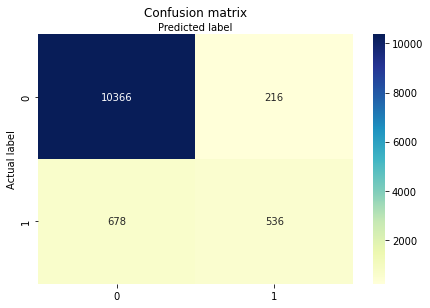

In [39]:
cnf_matrix = confusion_matrix(devy, devy_pred)
class_names=[0,1] # name  of classes
fig, ax = plt.subplots()
tick_marks = np.arange(len(class_names))
plt.xticks(tick_marks, class_names)
plt.yticks(tick_marks, class_names)
# create heatmap
sns.heatmap(pd.DataFrame(cnf_matrix), annot=True, cmap="YlGnBu" ,fmt='g')
ax.xaxis.set_label_position("top")
plt.tight_layout()
plt.title('Confusion matrix', y=1.1)
plt.ylabel('Actual label')
plt.xlabel('Predicted label');

In [46]:
print("Accuracy:", accuracy_score(devy, devy_pred))
print("Precision:", precision_score(devy, devy_pred))
print("Recall:", recall_score(devy, devy_pred))
print(classification_report(devy, devy_pred))
# print(accuracy_score(devy, devy_pred))

Accuracy: 0.9242115971515769
Precision: 0.7127659574468085
Recall: 0.4415156507413509
              precision    recall  f1-score   support

           0       0.94      0.98      0.96     10582
           1       0.71      0.44      0.55      1214

    accuracy                           0.92     11796
   macro avg       0.83      0.71      0.75     11796
weighted avg       0.92      0.92      0.92     11796



## Partial Dependency Plot

In [48]:
from sklearn.inspection import PartialDependenceDisplay

In [70]:
important_features = ["PROP_ITEMID_51006", "PROP_ITEMID_51301", "age", "ICU_STAY_DAYS", "PROP_ITEMID_50882"]


In [72]:
idx = [np.where(X.columns == name) for name in important_features]

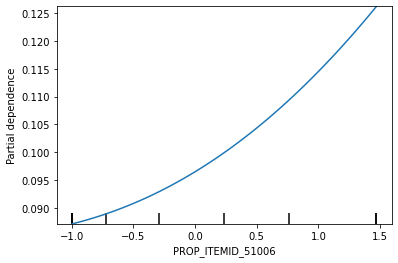

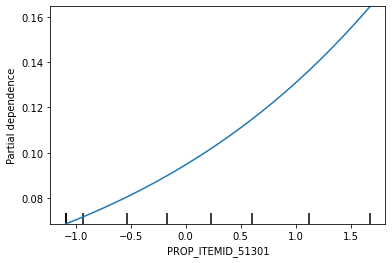

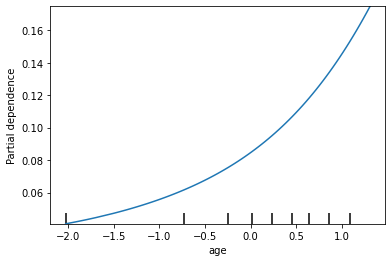

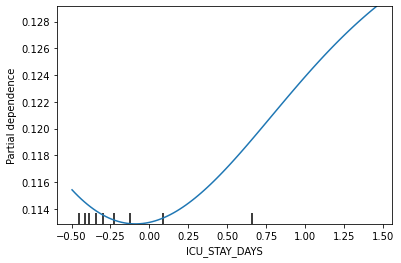

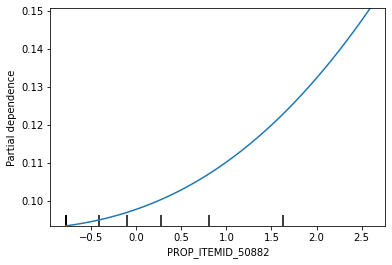

In [74]:
for i in idx:

  PartialDependenceDisplay.from_estimator(best_clf, trainX, features = i, feature_names=X.columns);